<a href="https://colab.research.google.com/github/guilhermecarva/guilhermecarva/blob/main/RedesNeurais_SistemaRecomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais aplicadas a Sitema de Recomendação

In [ ]:
!pip install emoji --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 6.0 MB/s eta 0:00:00


Importando as bibliotecas necessárias para nosso projeto

In [ ]:
import re
import os
import emoji
import spacy
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
%matplotlib inline

# Webscraping

criando função para fazer dataset de texto a partir de 3 editorias determinadas no site.

In [ ]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')

        news_articles = [{'news_headline': headline.find('span',
                                                       attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div',
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}

                          for headline, article in
                             zip(soup.find_all('div',
                                               class_=["LUWdd1C_3UqqulVsopn0"]), #LUWdd1C_3UqqulVsopn0  news-card-title news-right-box
                                 soup.find_all('div',
                                               class_=["LUWdd1C_3UqqulVsopn0"])) #KkupEonoVHxNv4A_D7UG  news-card-content news-right-box
                        ]
        news_data.extend(news_articles)

    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [ ]:
news_df = build_dataset(seed_urls)
news_df

,news_headline,news_article,news_category
0,"US, India, Taiwan representatives collaborate ...",A joint workshop was convened under the GCTF o...,technology
1,IIT Kanpur alumnus donates ₹1.6 cr to form 3 e...,IIT Kanpur alumnus Ashish Karandikar has donat...,technology
2,Apple Watch Innovation: External Flashlight In...,"The upcoming Apple Watch, hinted by a leaked p...",technology
3,New millimeter wave sensor measures extremely ...,"Researchers at the University of California, D...",technology
4,Ola Electric to file for IPO by December 20,Ola Electric will file its DRHP to list on Ind...,technology
5,First 100% SAF flight of Pratt & Whitney engin...,Pratt & Whitney Canada and Leonardo completed ...,technology
6,Samsung Boosts Team for Apple's Foldable Panels,Samsung intensified its focus on Apple's folda...,technology
7,New flow battery uses saltwater for long-durat...,AquaBattery is developing a sustainable and lo...,technology
8,OnePlus 12 5G Global Launch with Fast Charging...,The OnePlus 12 5G was released in China and aw...,technology
9,Paper Boat’s FY23 Loss Rises 71% To INR 90.6 Cr,The startup’s bottom line took a hit despite i...,technology


In [ ]:
news_df.to_csv('news_df_mentorama.csv')

Para saber:

- *Token*: uma unidade do texto, pode ser uma palavra, uma frase, etc.
- *Documento*: uma sequencia de tokens, por exemplo um livro ou um artigo
- *Corpus*: um conjunto de documentos.
- *Document Term Matrix*: uma matrix que descreve a frequencia de termos em um corpus
- *Stopwords*: palavras que não contém informação, que ocorrem com muita frequência.

Definindo função que processa o texto e retorna o texto tokenizado e sem stopwords, emoji, pontuação e números, etc:

In [ ]:
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",
    stem_words = True)
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", str(text))
    text = "".join([x for x in text if x not in emoji.EMOJI_DATA])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in ENGLISH_STOP_WORDS]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)

In [ ]:
rows, cols = news_df.shape

In [ ]:
#processando os textos
news_df['token'] = [preprocess_text(news_df["news_article"][row]) for row in range(rows)]

In [ ]:
news_df.head()

,news_headline,news_article,news_category,token
0,"US, India, Taiwan representatives collaborate ...",A joint workshop was convened under the GCTF o...,technology,"[joint, workshop, convened, gctf, monday, work..."
1,IIT Kanpur alumnus donates ₹1.6 cr to form 3 e...,IIT Kanpur alumnus Ashish Karandikar has donat...,technology,"[iit, kanpur, alumnus, ashish, karandikar, don..."
2,Apple Watch Innovation: External Flashlight In...,"The upcoming Apple Watch, hinted by a leaked p...",technology,"[upcoming, apple, watch, hinted, leaked, paten..."
3,New millimeter wave sensor measures extremely ...,"Researchers at the University of California, D...",technology,"[researchers, university, california, davis, d..."
4,Ola Electric to file for IPO by December 20,Ola Electric will file its DRHP to list on Ind...,technology,"[ola, electric, file, drhp, list, indian, bour..."


# Word Embedding

Depois que temos o texto com tokens, vamos usar uma rede neural que recebe palavras e entrega vetores que representam ela em um espaço vetorial.

# documentação importante:
https://spacy.io/usage

In [ ]:
!python -m spacy download en_core_web_md --quiet

2023-12-12 13:00:57.855962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 13:00:57.856041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 13:00:57.856090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 13:00:59.268879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:
# definindo função que retorna os vetores para cada palavra:
def vec(s):
    return nlp.vocab[s].vector

# Vetorizando cada palavra.
Aqui, como cada documento tem um número diferente de palavras, vamos ter matrizes com diferentes dimensões. Nosso objetivo final é conseguir representar cada documento como um vetor que resume o documento. Ou seja, queremos representar diferentes matrizes como vetores. Existem várias formas de fazer isso (média dos vetores, média ponderada pelo TF-IDF, PCA...), mas nesse teste vamos fazer uma média simples.

In [ ]:
vec_size = 300
list_of_matrix = []
for corpus in news_df['token']:
    matrix = np.empty([len(corpus), vec_size])
    for idx, word in enumerate(corpus):
        matrix[idx,:] = vec(word)
    list_of_matrix.append(matrix)

In [ ]:
final_feature_matrix = np.empty([rows, vec_size])

for row in range(rows):
    final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)

In [ ]:
final_feature_matrix.shape

(30, 300)

# Clusterização de matérias:

Agora que temos um vetor que representa cada documento, vamos usar algum método de clusterização pra tentar recuperar as editorias selecionadas lá no início. Vamos rodar um k-means em cada vetor que representa um documento e (como é um teste), pedir 3 clusters para ele.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=3, random_state=0).fit(final_feature_matrix)
kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0], dtype=int32)

Vamos ver como o k-means separou cada grupo e olhar o label verdadeiro para validar nosso método:

In [ ]:
print(news_df["news_category"][kmeans.labels_ == 0])
print(news_df["news_category"][kmeans.labels_ == 1])
print(news_df["news_category"][kmeans.labels_ == 2])

2     technology
3     technology
4     technology
5     technology
6     technology
7     technology
8     technology
29         world
Name: news_category, dtype: object
10    sports
11    sports
12    sports
13    sports
14    sports
15    sports
16    sports
17    sports
18    sports
19    sports
Name: news_category, dtype: object
0     technology
1     technology
9     technology
20         world
21         world
22         world
23         world
24         world
25         world
26         world
27         world
28         world
Name: news_category, dtype: object


Conseguimos separar bem as editorias por assuntos.

# Notícia mais similar usando distância euclidiana

Vamos agora tentar identificar, dado um documento, qual é o documento mais similar a ele.

In [ ]:
def get_closest(list_of_articles, article_position, df):
    article_vec = list_of_articles[article_position,:]
    other_vec = np.delete(list_of_articles, article_position, 0)
    from scipy import spatial
    A = [other_vec[row,:] for row in range(other_vec.shape[0])]
    tree = spatial.KDTree(A)
    closest_position = tree.query(article_vec)[1]
    print(df[article_position].string)
    print(df[closest_position].string)
    return tree.query(article_vec)[0], closest_position

In [ ]:
get_closest(final_feature_matrix, 10, news_df["news_article"])

Ex-Chelsea footballer John Obi Mikel said Manchester United footballer Anthony Martial moans and shakes his head, adding that he is never able to understand what Martial does at a football club. "If you're not playing well...kick somebody. Start a fight," he added. "Sometimes when I see him on the pitch...I'm like, 'Is he still in this team?'" he stated.
A video has gone viral showing Sydney Sixers all-rounder Tom Curran getting scared of pitchside flames following a boundary in their Big Bash League match against Hobart Hurricanes. In the video, Curran can be seen jumping after being frightened due to the sudden fireworks. In the video, the commentators can be heard laughing.


(11.167469377574438, 13)

# Explorando visualmente os resultados encontrados

Como estamos lidando com uma dimensão elevada (300) para cada documento, não conseguimos visualizar com clareza o que estamos clusterizando. Um método simples que permite explorar os resultados obtidos é reduzir a dimensão do problema para 2, 3 e fazer gráficos exploratórios que permitam visualizar os dados.


Para este exercício vamos reduzir as 300 dimensões para 4 dimensões

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(final_feature_matrix)
principalDf = pd.DataFrame(data = principalComponents
             ,columns = ['Comp1', 'Comp2', 'Comp3'])

In [ ]:
pca.explained_variance_

array([42.8263851 , 28.54836173, 19.41461258])

In [ ]:
pca.explained_variance_ratio_   #fornece uma ideia de quanta variação é explicada pelos componentes principais (em percentual)

array([0.20928012, 0.13950756, 0.09487358])

### Obtivemos menos de 50% somando os 3 componentes. O ideal seria termos algo em torno de 80% para evitarmos overfitting e ao mesmo tempo conseguir que os componentes expliquem de forma precisa.

In [ ]:
pca.noise_variance_

4.2165668002980485

Aqui, vamos plotar o gráfico dos dois primeiros componentes e colorir eles com a cor associada à editoria real dele.

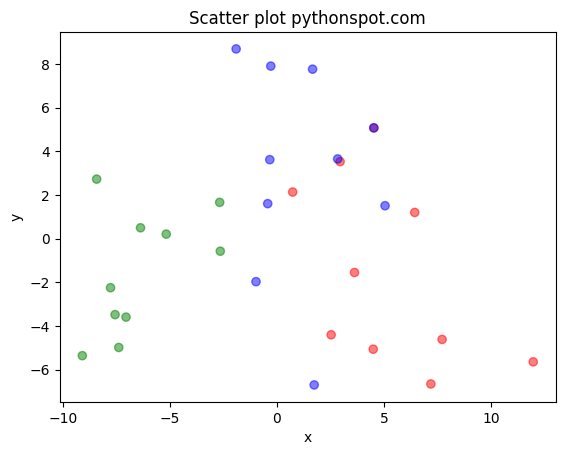

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create data

x = principalDf['Comp1']
y = principalDf['Comp2']

# Plot

colors = {'technology':'red', 'world':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Agora vamos plotar os 3 componentes utilizando um gráfico 3D

Text(0.5, 0, 'Comp3')

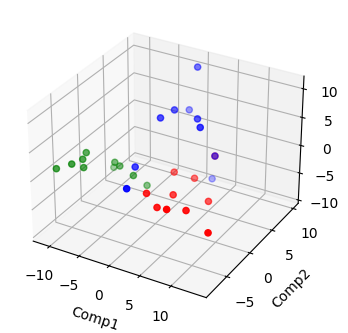

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4,4))

axis = fig.add_subplot(111, projection='3d')

colors = {'technology':'red', 'world':'blue', 'sports':'green'}
axis.scatter(principalDf['Comp1'],principalDf['Comp2'],principalDf['Comp3'], c=news_df['news_category'].apply(lambda x: colors[x]))
axis.set_xlabel("Comp1", fontsize=10)
axis.set_ylabel("Comp2", fontsize=10)
axis.set_zlabel("Comp3", fontsize=10)

### Agora vamos utilizar outro método de redução de dimensionalidade ( MDS - Multi-dimensional Scaling )

In [ ]:
from sklearn.manifold import MDS

Vamos utilizar o método com 3 compomentes para que tenhamos uma comparação justa com o método utilizado anteriormente (PCA)

In [ ]:
mds = MDS(n_components=3, metric=False, normalized_stress=True)
transformed = mds.fit_transform(final_feature_matrix)
mdsDf = pd.DataFrame(data = transformed,columns = ['Comp1', 'Comp2', 'Comp3'])

In [ ]:
mdsDf.shape

(30, 3)

In [ ]:
mds.n_iter_ #número de iterações feitas para atingir o melhor resultado

182

In [ ]:
mds.stress_  #A value of 0 indicates “perfect” fit, 0.025 excellent, 0.05 good, 0.1 fair, and 0.2 poor

0.22236703112089534

### Obtivemos um valor de 0.2, o que significa um resultado "pobre"

Text(0.5, 0, 'Comp3')

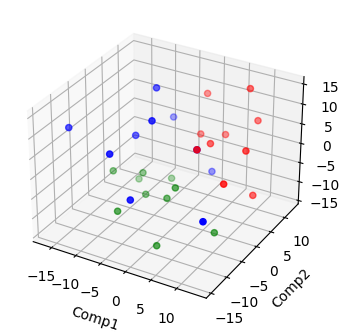

In [ ]:
fig = plt.figure(figsize=(4,4))

axis = fig.add_subplot(111, projection='3d')

colors = {'technology':'red', 'world':'blue', 'sports':'green'}
axis.scatter(mdsDf['Comp1'],mdsDf['Comp2'],mdsDf['Comp3'], c=news_df['news_category'].apply(lambda x: colors[x]))
axis.set_xlabel("Comp1", fontsize=10)
axis.set_ylabel("Comp2", fontsize=10)
axis.set_zlabel("Comp3", fontsize=10)

Os dois métodos utilizados acima são técnicas poderosas para redução de dimensionalidade e data visualization.<br>
Ambos se baseam em transformação linear, no entanto, O MDS foca mais em preservar distâncias entre pares, enquanto o PCA foca em capturar a variação máxima nos dados. <br>O MDS trabalha diretamente com uma matriz de distância, enquanto o PCA opera na matriz de dados original.

# Em ambos os métodos obtivemos uma resultado não tão satisfatório, mas ainda sim o PCA se saiu melhor , tanto na métrica quanto visualmente.

Vamos tentar melhorar o resultado do PCA adicionando mais componentes

In [ ]:
pca2 = PCA(n_components=5)
principalComponents = pca2.fit_transform(final_feature_matrix)
sum(pca2.explained_variance_ratio_)

0.5816141729397774

In [ ]:
pca3 = PCA(n_components=7)
principalComponents = pca3.fit_transform(final_feature_matrix)
sum(pca3.explained_variance_ratio_)

0.6782653323079375

In [ ]:
pca4 = PCA(n_components=10)
principalComponents = pca4.fit_transform(final_feature_matrix)
print(sum(pca4.explained_variance_ratio_))
print(pca4.explained_variance_ratio_)

0.7820586346554859
[0.20928012 0.13950756 0.09487358 0.07661564 0.06133728 0.05086519
 0.04578597 0.04016379 0.03293265 0.03069685]


Com esta análises adicionais, podemos observar que a partir de uma certa quantidade de componentes, eles acrescentam muito pouco a explicação da variação. Portanto, utilizar algo em torno de 4 ou 5 componentes estaria de bom tamanho.

Agora, somente por questões educacionais ("curiosidade"), vamos adicionar mais componentes ao MDS.

In [ ]:
mds2 = MDS(n_components=5, metric=False, normalized_stress=True)
transformed = mds2.fit_transform(final_feature_matrix)
mds2.stress_

0.17295932124707697

In [ ]:
mds3 = MDS(n_components=7, metric=False, normalized_stress=True)
transformed = mds3.fit_transform(final_feature_matrix)
mds3.stress_

0.14152067759425074

In [ ]:
mds4 = MDS(n_components=10, metric=False, normalized_stress=True)
transformed = mds4.fit_transform(final_feature_matrix)
mds4.stress_

0.10900342816925157

Já com o MDS, não conseguimos um bom resultado com 5 componentes, precisaríamos de no mínimo 10 para atingir um stress_ de 0.1 (que é considerado justo).

# Conclusão<br>
Os dois métodos utilizados tem a mesma finalidade e conseguem obter bons resultados se parametrizados de acordo.